# CNN Model for Toxic Language Classification

## Set up

##### Load packages

In [5]:
%%capture

import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import nltk
nltk.download("all")
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

%matplotlib inline

##### Set Parameters

In [6]:
BATCH_SIZE = 16
MAX_SENT_LENGTH = 200
EMBED_DIM = 300

device = cuda.

##### Load data

In [7]:
# load balanced data
data = pd.read_csv("../data/balanced_data.csv")
data = data[data["word_count"] <= MAX_SENT_LENGTH]
data = data.reset_index()
data = data[["comment_text", "toxic"]]
data.head(5)

,id,comment_text,toxic
0,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1
1,2b77b61ee27ab6fb,Not according to Wikipedia policy. With respec...,0
2,626d12d910b34c40,"You just revert my and a lot of peoples work, ...",1
3,2ed8095b9ee464b0,"Frank O'Hara, Anti-Beat? \nSeriously, dude, yo...",0
4,86f8607fd0572b9f,"""\n\nreverting\nUser:Baristarim decides that t...",0


In [8]:
len(data)

28929

##### GPU set up

In [29]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


##### Pre-trained text embedding set up 

**GloVe**

In [9]:
from itertools import combinations
from torchtext.vocab import GloVe

VECTOR_CACHE_DIR = './glove/.vector_cache'

glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

print(glove.get_vecs_by_tokens(["this", "is", "a", "comment"]))
print(glove.get_vecs_by_tokens(["this", "is", "a", "comment"]).shape)

tensor([[-0.2044,  0.1643,  0.0418,  ..., -0.3401, -0.0771, -0.0841],
        [-0.1749,  0.2296,  0.2492,  ..., -0.2413, -0.4040,  0.0547],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        [ 0.2887, -0.5307, -0.0883,  ..., -0.2334, -0.2379,  0.3161]])
torch.Size([4, 300])


## Data Preparation


##### Tokenize word and map with embeddings

In [10]:
from nltk.tokenize import word_tokenize

def process_input(batch):
    '''
    Tokenize a batch of texts:
        - convert sentence to lower case
        - tokenize word with package `word_tokenize`
        - add paddings to MAX_SENT_LENGTH
        - convert tokenized sentence into GloVe embeddings
        - return a numpy array of input vectors 
    '''

    # set up containers
    y = torch.zeros(BATCH_SIZE)
    x = torch.zeros(BATCH_SIZE, MAX_SENT_LENGTH, EMBED_DIM)
    
    for i, (sent, label) in enumerate(batch):

        sent = sent.lower()
        tokenized_sent = word_tokenize(sent)

        # perform padding or truncate
        if len(tokenized_sent) < MAX_SENT_LENGTH:
            tokenized_sent += ['<pad>'] * (MAX_SENT_LENGTH - len(tokenized_sent))
        else:
            tokenized_sent = tokenized_sent[:MAX_SENT_LENGTH]

        vecs = glove.get_vecs_by_tokens(tokenized_sent)

        x[i] = vecs
        y[i] = label
    
    y = y.type(torch.LongTensor)

    return x, y 

# def process_input(batch):
#     '''
#     Tokenize a batch of texts:
#         - convert sentence to lower case
#         - tokenize word with package `word_tokenize`
#         - add paddings to MAX_SENT_LENGTH
#         - convert tokenized sentence into GloVe embeddings
#         - return a numpy array of input vectors 
#     '''

#     # set up containers
#     y = torch.zeros(BATCH_SIZE)
#     x = torch.zeros(BATCH_SIZE, MAX_SENT_LENGTH)
    
#     for i, (sent, label) in enumerate(batch):

#         sent = sent.lower()
#         tokenized_sent = word_tokenize(sent)

#         # perform padding or truncate
#         if len(tokenized_sent) < MAX_SENT_LENGTH:
#             tokenized_sent += ['<pad>'] * (MAX_SENT_LENGTH - len(tokenized_sent))
#         else:
#             tokenized_sent = tokenized_sent[:MAX_SENT_LENGTH]

#         x[i] = torch.tensor(tokenized_sent)
#         y[i] = label

#     return x, y 

##### Custome Dataset

In [11]:
# customized dataset: 

class CustomDataset(Dataset):
    '''
    '''
    def __init__(self, df):
        # self.is_test = is_test
        self.dataframe = df
        self.label_name = df.columns[-1]
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['comment_text']
        label = self.dataframe.iloc[idx][self.label_name]
        return text, label


##### Create Data Loader

In [72]:
# split data: train 70%, validation 20%, test 10%

train_df, rest_df = train_test_split(data, test_size=0.3, random_state=1)
val_df, test_df = train_test_split(rest_df, test_size=0.33, random_state=1)

# convert dataframes into cusmotized datasets

train_data = CustomDataset(train_df)
val_data = CustomDataset(val_df)
test_data = CustomDataset(test_df)

# create dataloader
# droplast: if last batch is incomplete, we drop the last batch

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                              collate_fn=process_input, drop_last=True)

val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, 
                            collate_fn=process_input, drop_last=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, 
                             collate_fn=process_input, drop_last=True)

In [277]:
# for i, (text, label) in enumerate(test_dataloader):
#     print(i)
#     print(text)
#     print(label)

#     if i == 2:
#         break

## Modeling


##### CNN Version 0 </p>

For the first model, we are testing the following parameters

|Description         |Values           |
|:------------------:|:---------------:|
|input word vectors  |GloVe            |
|embedding size      |300              |
|filter sizes        |(2, 3, 4, 5)     |
|num filters         |(64, 64, 64, 64) |
|activation          |ReLU             |
|pooling             |1-max pooling    |
|dropout rate        |0.5              |

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    '''
    An 1D Convulational Neural Network for Sentence Classification.
    '''

    def __init__(self, filter_sizes=[2, 3, 4, 5], num_filters=[64, 64, 64, 64], 
                 embed_dim=EMBED_DIM, num_classes=2, dropout=0.5):
        """

        Args:
            pretrained_embedding (torch.Tensor): size (max_sent_length, embed_dim)
            freeze_embedding (bool): set to False by default
            max_sent_length (int): longest sentence allowed
            embed_dim (int): dimension of word vectors, by default: 300
            filter_sizes (List[int]): list of filter sizes, by default: [2, 3, 4, 5]
            num_filters (List[int]): list of number of filters, [64] * 4
            n_classes (int): number of classes, by default: 2
            dropout (float): Dropout rate, by default: 0.5
        """

        super(CNN_NLP, self).__init__()

        # # Embedding layer
        # if pretrained_embedding is not None:
        #     self.vocab_size, self.embed_dim = pretrained_embedding.shape
        #     self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
        #                                                   freeze=freeze_embedding)
        # else:
        #     self.embed_dim = embed_dim
        #     self.embedding = nn.Embedding(num_embeddings=vocab_size,
        #                                   embedding_dim=self.embed_dim,
        #                                   padding_idx=0,
        #                                   max_norm=5.0)

        self.embed_dim = embed_dim
        
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim, 
                      out_channels=num_filters[i], 
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))])
        
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input):
        """Perform a forward pass through the network.

        Args:
            input (torch.Tensor): tensor of batch of sentences with shape
            (batch_size, max_sent_length, embedding_dim)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
            n_classes)
        """

        # permute input to match the shape requirement of `nn.Conv1d`.
        # x_reshaped shape: (BATCH_SIZE, EMBED_DIM, MAX_SENT_LENGTH)
        x_reshaped = input.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

## Training

In [14]:
import torch.optim as optim

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")

def initilize_model(embed_dim=EMBED_DIM, filter_sizes=[2, 3, 4, 5], num_filters=[64, 64, 64, 64], 
                    num_classes=2, dropout=0.5, learning_rate=0.01):

    '''
    Instantiate a CNN model and an optimizer.
    '''

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        embed_dim=embed_dim,
                        num_classes=num_classes,
                        dropout=dropout)
    
    cnn_model.to(device)

    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [37]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    '''
    Set seed for reproducibility.
    '''

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


def evaluate_val(model, val_dataloader):
    '''
    After the completion of each training epoch, 
    measure the model's performance on our validation set.
    '''

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:

        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


def train(model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=False):
    '''
    Train the CNN model.
    '''
    
    best_model = None
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):

        t0_epoch = time.time()
        total_loss = 0
        model.train()

        # ============= Training =============

        for step, batch in enumerate(train_dataloader):

            # forward and compute loss
            b_input, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        time_elapsed = time.time() - t0_epoch

        # ============= Evaluation =============

        val_loss, val_accuracy = evaluate_val(model, val_dataloader)

        if not best_model:
            best_model = model

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

    if check_train_loss:
        return best_model, val_accuracies, val_losses, train_losses, 
    return best_model, val_accuracies, val_losses

## Testing

In [39]:
from sklearn.metrics import confusion_matrix

def test_model(model, test_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

# def test_model(model, test_dataloader, compare_data=False):
#     '''
#     test the model on test data, return a DataFrame 
#     of ID, prediction label and actural label
#     '''

#     model.eval()

#     predictions = []
#     labels = []
#     losses = []
#     # ids = []
#     # ids.to(device)
#     # predictions.to(device)
#     # labels.to(device)

#     for i, batch in enumerate(test_dataloader):

#         b_input, b_labels = tuple(t.to(device) for t in batch)

#         with torch.no_grad():
#             logits = model(b_input)

#         loss = loss_fn(logits, b_labels)
#         losses.append(loss.item())
#         preds = torch.argmax(logits, dim=1).flatten()

#         # ids.extend(list(b_ids))
#         labels.extend(list(b_labels))
#         predictions.extend(list(preds))

#         if i % 200 == 0 and i != 0:
#             print("After {} batches, the loss is {}".format(i, loss))


    # test_loss = np.mean(losses)

    # if we need to check predictions and labels, 
    # return test_loss and a pred-label dataframe

    # if compare_data:
    #     performance = {"prediction": predictions,
    #                    "label": labels}
    #     return test_loss, pd.DataFrame(performance)
    
    # if we only need to check model performance, 
    # return test_loss and confusion matrix
    
    # else:
    #     cm = confusion_matrix(labels, predictions)
    #     return test_loss, cm

def eval_cm(cm):
    '''
    ravel a comfusion matrix, and return 
    accuracy, precision, recall, f1 
    '''
    tn, fp, fn, tp = cm.ravel() 
    accu = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (prec * recall) / (prec + recall)

    eval = {"Accuracy": [accu],
            "Precision": [prec],
            "Recall": [recall],
            "F1": [f1]}
    
    return pd.DataFrame(eval)


In [76]:
def get_predictions(model, test_dataloader):
    '''
    After the completion of each training epoch, measure the model's
    performance on our validation set.
    '''

    model.eval()
    preds = []

    for batch in test_dataloader:
        b_input, _ = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)
        b_pred = torch.argmax(logits, dim=1).flatten()
        for v in b_pred:
            preds.append(int(v))

    return preds


def get_tag(row):
    '''
    helper function to get 4 different tags based on 
    the predicted value and the actual value: 
    "TP", "TN", "FP", "FN" 

    the labels are binary, so we only have 4 conditions:
        label(1) * pred(1) = 1  ---> "TP"
        label(0) - pred(0) = 0  ---> "TN" (excluding previous condition)
        label(0) - pred(1) = -1 ---> "FP" (excluding previous conditions)
        label(1) - pred(0) = 1  ---> "FN" (excluding previous conditions)
    '''
    
    pred = row["pred"]
    label = row["label"]

    if label * pred == 1:
        return 'TP'
    elif label - pred == 0:
        return 'TN'
    elif label - pred == -1:
        return 'FP'
    elif label - pred == 1:
        return 'FN'
    else:
        return 'N/A'


def tag_performances(preds, df):
    '''
    take predictions from model on test_df, tag 
    cases of prediction: "TP", "TN", "FP", "FN" 
    preds: [list] 
    test_data: [DataFrame]
    '''

    N = len(preds)

    assert N == len(df) - (len(df) % 16), \
    "AssertionError: number of predictions should equal to the number of examples"

    # change the last column name
    last_column_name = df.columns[-1]
    df = df.rename(columns={last_column_name: "label"})

    # add new column for model predictions
    df = df[: N]
    df["pred"] = preds

    # tag "TP", "TN", "FP", "FN" for each pair
    df['tag'] = df.apply(get_tag, axis=1)

    return df

## Compare Different Models

#### REPORT 1 `best_model_0`:

In [30]:
# train model with 10 epocks
cnn_model, optimizer = initilize_model()
best_model_0, val_accuracies_0, val_losses_0 = train(cnn_model, optimizer, train_dataloader, val_dataloader)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.528128   |  0.399364  |   85.30   |  226.91  
   2    |   0.363661   |  0.317377  |   87.72   |  229.22  
   3    |   0.311483   |  0.287456  |   88.62   |  228.62  
   4    |   0.283751   |  0.271325  |   89.22   |  226.00  
   5    |   0.268967   |  0.261541  |   89.65   |  212.46  
   6    |   0.258044   |  0.254281  |   89.94   |  199.25  
   7    |   0.248379   |  0.248118  |   90.05   |  203.42  
   8    |   0.240250   |  0.243319  |   90.29   |  205.28  
   9    |   0.232290   |  0.239913  |   90.67   |  205.68  
  10    |   0.225141   |  0.236111  |   90.58   |  236.86  


Training complete! Best accuracy: 90.67%.


In [32]:
val_accuracies_0

[85.2961432506887,
 87.72382920110194,
 88.61914600550965,
 89.22176308539945,
 89.65220385674931,
 89.94490358126721,
 90.04820936639119,
 90.2892561983471,
 90.66804407713498,
 90.58195592286502]

Text(0.5, 1.0, 'Validation accuracy of `best_model_0` (10 epochs)')

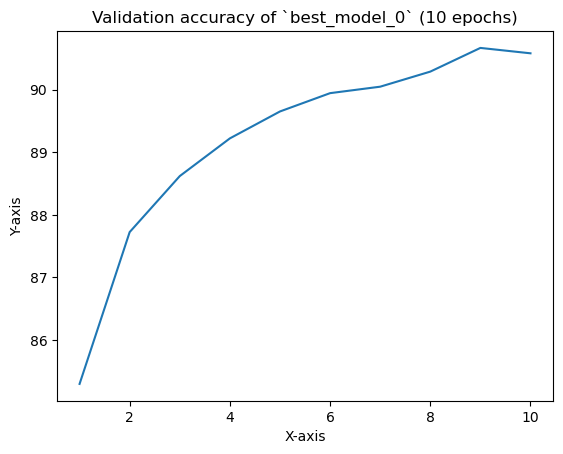

In [36]:
epochs = [x+1 for x in range(10)]

plt.plot(epochs, val_accuracies_0)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Validation accuracy of `best_model_0` (10 epochs)')



**Report:** </p>

```python

(CNN_NLP(
   (conv1d_list): ModuleList(
     (0): Conv1d(300, 64, kernel_size=(2,), stride=(1,))
     (1): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
     (2): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
     (3): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
   )
   (fc): Linear(in_features=256, out_features=2, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
 )
```

**Training performance:**

| Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
|:------:|:------------:|:----------:|:---------:|:-------:|
|   1    |   0.515071   |  0.387810  |   85.50   |  222.95 | 
|   2    |   0.357476   |  0.314949  |   87.84   |  214.95 |
|   3    |   0.307458   |  0.286911  |   88.58   |  217.30 |
|   4    |   0.283827   |  0.271694  |   89.29   |  212.41 |
|   5    |   0.269294   |  0.261957  |   89.29   |  217.79 |
|   6    |   0.257123   |  0.254316  |   89.50   |  238.22 |
|   7    |   0.247575   |  0.248300  |   89.76   |  223.09 |
|   8    |   0.239426   |  0.243885  |   89.81   |  216.53 |
|   9    |   0.233904   |  0.239794  |   90.08   |  210.70 |
|  10    |   0.227885   |  0.236559  |   90.17   |  221.15 |


Next, let's see some of the false prediction results:

In [84]:
preds = get_predictions(best_model_0, test_dataloader)
results_cnn_0 = tag_performances(preds, test_df)

In [105]:
# check some of the false negative predictions
false_neg_cnn_0 = results_cnn_0[results_cnn_0["tag"] == "FN"]
false_neg_cnn_0.to_csv("FN_model0.csv")
false_neg_cnn_0.head(5)

,id,comment_text,label,pred,tag
1841,12a1805ef86d1267,"He is not gay in Rugrats, but on the internet,...",1,0,FN
1154,9e25d9bb1e79ede6,Unfairly blocked as Mattythewhite got the hump...,1,0,FN
28361,a3b68ab21bbd0439,WHY DID THEY DELETED IT BECAUSE I MADE IT THAT...,1,0,FN
24142,13d34f8041fbec39,Cease and defuck\nYour work is a fuckability. ...,1,0,FN
19656,24d25ca2fe7e07ea,"User, YOU ARE MISTAKEN. THE CAPITAL HILL BLUE...",1,0,FN


In [106]:
# check some of the false positive predictions
false_pos_cnn_0 = results_cnn_0[results_cnn_0["tag"] == "FP"]
false_pos_cnn_0.to_csv("FP_model0.csv")
false_pos_cnn_0.head(5)

,id,comment_text,label,pred,tag
19916,7ab55f5165ed9291,The failure of Fagreterion \n\nFagreterion can...,0,1,FP
6032,0be7965b23078261,"""Just face the truth: you can't escape it!==\n...",0,1,FP
7878,7f0f1a7286ecbc51,hayyyyyyyyy \n\nyeah this karoolzzz hay k hayy...,0,1,FP
26972,96b055eca6cc56b0,a debate to see why he was so virulently anti-...,0,1,FP
5618,f97e67368b5eee9d,"Well, I seemed to be able to change it just fi...",0,1,FP


In [109]:
# for i, row in false_neg_cnn_0.iterrows():
#     id = row["id"]
#     sent = row["comment_text"]
#     print("id:")
#     print(id)
#     print("comment: ")
#     print(sent)
#     print("============")

Try the same model with 30 epochs to show overfitting:

In [ ]:
# train model with 30 epochs
cnn_model, optimizer = initilize_model()
best_model_0_30, val_accuracies_0_30, val_losses_0_30, train_losses_0_30 = \
    train(cnn_model, optimizer, train_dataloader, val_dataloader, epochs=30, check_train_loss=True)

In [ ]:
epochs = [x+1 for x in range(10)]

plt.plot(epochs, val_accuracies_0)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Validation accuracy of `best_model_0` (10 epochs)')


In [31]:

# # pickle a model
# with open('best_model_0.pkl', 'wb') as file:
#     pickle.dump(best_model_0, file)

# # load the pickled model
# with open('best_model_0.pkl', 'rb') as file:
#     best_model_0 = pickle.load(file)

In [22]:
from sklearn.metrics import confusion_matrix

def test_model(model, test_dataloader, compare_data=False):
    '''
    test the model on test data, return a DataFrame 
    of ID, prediction label and actural label
    '''

    model.eval()

    predictions = []
    labels = []
    losses = []
    # ids = []
    # ids.to(device)
    # predictions.to(device)
    # labels.to(device)

    for i, batch in enumerate(test_dataloader):

        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()

        # ids.extend(list(b_ids))
        labels.extend(list(b_labels))
        predictions.extend(list(preds))

        if i % 200 == 0 and i != 0:
            print("After {} batches, the loss is {}".format(i, loss))


    test_loss = np.mean(losses)

    # if we need to check predictions and labels, 
    # return test_loss and a pred-label dataframe

    if compare_data:
        performance = {"prediction": predictions,
                       "label": labels}
        return test_loss, pd.DataFrame(performance)
    
    # if we only need to check model performance, 
    # return test_loss and confusion matrix
    
    else:
        cm = confusion_matrix(labels, predictions)
        return test_loss, cm

def eval_cm(cm):
    '''
    ravel a comfusion matrix, and return 
    accuracy, precision, recall, f1 
    '''
    tn, fp, fn, tp = cm.ravel() 
    accu = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (prec * recall) / (prec + recall)

    eval = {"Accuracy": [accu],
            "Precision": [prec],
            "Recall": [recall],
            "F1": [f1]}
    
    return pd.DataFrame(eval)


In [302]:
# test_loss, cm = test_model(best_model_0, test_dataloader)

In [290]:
def test_model(model, test_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [24]:
# Load the model
with open('best_model_og.pkl', 'rb') as file:
    best_model_og = pickle.load(file)